In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adagrad
from torch.nn import BCEWithLogitsLoss

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


store undersampled data from the other notebook

In [2]:
%store -r data #this is the original training dataset after being processed: only the columns "Argument_ID" and "processed_text" are included here

%store -r df #stored from the notebook undersampling.ipynb, represents the balanced dataset after undersampling was applied

no stored variable or alias #this
no stored variable or alias is
no stored variable or alias the
no stored variable or alias original
no stored variable or alias training
no stored variable or alias dataset
no stored variable or alias after
no stored variable or alias being
no stored variable or alias processed:
no stored variable or alias only
no stored variable or alias the
no stored variable or alias columns
no stored variable or alias Argument_ID
no stored variable or alias and
no stored variable or alias processed_text
no stored variable or alias are
no stored variable or alias included
no stored variable or alias here
no stored variable or alias #stored
no stored variable or alias from
no stored variable or alias the
no stored variable or alias notebook
no stored variable or alias undersampling.ipynb,
no stored variable or alias represents
no stored variable or alias the
no stored variable or alias balanced
no stored variable or alias dataset
no stored variable or alias after
no 

In [3]:
%store -r validation_set #The validation set, preprocessed in preprocessing validation.ipynb

In [4]:
validation_set = validation_set[["Argument ID", "Premise", "Openness to change", "Self-Enhancement", "Conservation", "Self-Transcendence", "general_label"]]

In [5]:
validation_set.head(5)

,Argument ID,Argument ID,Premise,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,general_label
0,A01001,A01001,if entrapment can serve to more easily capture...,0,0,1,0,"[0, 0, 1, 0]"
1,A01012,A01012,the use of public defenders should be mandator...,0,0,0,1,"[0, 0, 0, 1]"
2,A02001,A02001,payday loans create a more impoverished societ...,0,0,1,1,"[0, 0, 1, 1]"
3,A02002,A02002,Surrogacy should not be banned as it is the wo...,1,0,0,0,"[1, 0, 0, 0]"
4,A02009,A02009,entrapment is gravely immoral and against huma...,0,0,1,2,"[0, 0, 1, 2]"


In [6]:
data

,Argument_ID,processed_text
0,A01002,we should ban human cloning as it will only ca...
1,A01005,fast food should be banned because it is reall...
2,A01006,sometimes economic sanctions are the only thin...
3,A01007,capital punishment is sometimes the only optio...
4,A01008,factory farming allows for the production of c...
...,...,...
5387,E08016,on the one hand we have russia killing countle...
5388,E08017,the subsidies were originally intended to ensu...
5389,E08018,these products come mainly from large enterpri...
5390,E08019,subsidies often make farmers in recipient coun...


In [7]:
df 

,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


In [8]:
df = df.rename(columns={'Argument ID': 'Argument_ID'})


In [9]:
#Uniforming the validation set and the training set
validation_set = validation_set.rename(columns={"Argument ID": "Argument_ID"})
validation_set = validation_set.rename(columns={"general_label": "labels"})
validation_set = validation_set.rename(columns={"Premise": "processed_text"})

In [10]:
validation_set

,Argument_ID,Argument_ID,processed_text,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01001,A01001,if entrapment can serve to more easily capture...,0,0,1,0,"[0, 0, 1, 0]"
1,A01012,A01012,the use of public defenders should be mandator...,0,0,0,1,"[0, 0, 0, 1]"
2,A02001,A02001,payday loans create a more impoverished societ...,0,0,1,1,"[0, 0, 1, 1]"
3,A02002,A02002,Surrogacy should not be banned as it is the wo...,1,0,0,0,"[1, 0, 0, 0]"
4,A02009,A02009,entrapment is gravely immoral and against huma...,0,0,1,2,"[0, 0, 1, 2]"
...,...,...,...,...,...,...,...,...
1571,D02068,D02068,"As per the government data of 2017, the averag...",1,1,0,0,"[1, 1, 0, 0]"
1572,D02069,D02069,"At present, child marriages are happening thro...",0,1,1,2,"[0, 1, 1, 2]"
1573,D02070,D02070,Several girls are being forced into marriages ...,1,0,2,1,"[1, 0, 2, 1]"
1574,D03043,D03043,Many people are dying of hunger in India. Hung...,0,0,2,1,"[0, 0, 2, 1]"


In [11]:
# Merge based on the 'ID' column
merged_df = pd.merge(data, df, on='Argument_ID', how='inner')

print(merged_df)

     Argument_ID                                     processed_text  \
0         A01002  we should ban human cloning as it will only ca...   
1         A01005  fast food should be banned because it is reall...   
2         A01006  sometimes economic sanctions are the only thin...   
3         A01007  capital punishment is sometimes the only optio...   
4         A01008  factory farming allows for the production of c...   
...          ...                                                ...   
2765      E08005  absolutely right europe needs an army for cont...   
2766      E08008  in principle i would be in favor of a european...   
2767      E08009  i agree with your idea but it is a long and ar...   
2768      E08016  on the one hand we have russia killing countle...   
2769      E08020  the eu can not endlessly lean on america or na...   

      Openness to change  Self-Enhancement  Conservation  Self-Transcendence  \
0                      0                 0             1           

In [12]:
merged_df.head()

,Argument_ID,processed_text,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,we should ban human cloning as it will only ca...,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,fast food should be banned because it is reall...,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,sometimes economic sanctions are the only thin...,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,capital punishment is sometimes the only optio...,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,factory farming allows for the production of c...,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."


In [13]:
merged_df["labels"]

0                                    [0.0, 0.0, 1.0, 0.0]
1                                    [0.0, 0.0, 1.0, 0.0]
2                                    [0.0, 0.5, 0.5, 0.0]
3       [0.0, 0.0, 0.6666666666666666, 0.3333333333333...
4       [0.0, 0.0, 0.3333333333333333, 0.6666666666666...
                              ...                        
2765                               [0.0, 0.25, 0.5, 0.25]
2766    [0.0, 0.3333333333333333, 0.3333333333333333, ...
2767                                 [0.0, 0.5, 0.5, 0.0]
2768                               [0.0, 0.5, 0.25, 0.25]
2769                             [0.25, 0.25, 0.25, 0.25]
Name: labels, Length: 2770, dtype: object

In [14]:
validation_set["labels"]

0       [0, 0, 1, 0]
1       [0, 0, 0, 1]
2       [0, 0, 1, 1]
3       [1, 0, 0, 0]
4       [0, 0, 1, 2]
            ...     
1571    [1, 1, 0, 0]
1572    [0, 1, 1, 2]
1573    [1, 0, 2, 1]
1574    [0, 0, 2, 1]
1575    [1, 2, 1, 1]
Name: labels, Length: 1576, dtype: object

BERT will be applied on binarized labels instead of probability distributions, so labels need to be binarized

In [15]:
#Binarization of labels in the training set
labels_binarized=[]

for label in merged_df.labels:
    labels=[]
    for sublabel in label:
        if sublabel>0:
            labels.append(1)
        else:
            labels.append(0)
    labels_binarized.append(labels)

In [16]:
#Binarization of labels in the validation set.
labels_binarized2=[]

for label in validation_set.labels:
    labels=[]
    for sublabel in label:
        if sublabel>0:
            labels.append(1)
        else:
            labels.append(0)
    labels_binarized2.append(labels)

In [17]:
labels_binarized

[[0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 1, 1, 0],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [1, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 1, 1],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [1, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 0, 0],
 [0, 0, 1, 1],
 [1, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 1, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 0, 1],
 [1, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 1, 0, 1],
 [0, 0, 0,

In [18]:
labels_binarized2

[[0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [1, 0, 0, 0],
 [0, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 0],
 [0, 1, 1, 0],
 [0, 1, 0, 1],
 [0, 0, 1, 1],
 [1, 0, 1, 0],
 [1, 0, 1, 1],
 [0, 0, 1, 1],
 [0, 1, 1, 0],
 [1, 0, 1, 0],
 [1, 0, 0, 1],
 [1, 0, 0, 1],
 [1, 1, 1, 1],
 [1, 1, 0, 1],
 [1, 1, 0, 0],
 [1, 0, 0, 0],
 [1, 1, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 1, 1],
 [1, 1, 0, 0],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [1, 0, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 1, 0],
 [1, 1, 1, 0],
 [0, 0, 1, 1],
 [1, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [0, 0, 1, 1],
 [1, 0, 1, 1],
 [1, 1, 1, 1],
 [1, 0, 1, 1],
 [1, 0, 1, 1],
 [0, 0, 1, 1],
 [1, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 1, 1, 1],
 [1, 1, 1, 1],
 [0, 0, 1, 1],
 [1, 1, 1, 1],
 [1, 0, 1, 1],
 [1, 0, 0, 1],
 [0, 1, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 1, 1],
 [1, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 1, 0, 1],
 [0, 1, 1, 1],
 [0, 0, 1, 0],
 [1, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 1, 1,

In [19]:
df_labels = pd.DataFrame(labels_binarized)

In [20]:
val_labels = pd.DataFrame(labels_binarized2)

In [21]:
# we combine the original data with binarized labels
df_combined = pd.concat([merged_df['processed_text'], df_labels], axis=1)

In [22]:
#We combine also the validation set with their binarized labels
val_combined = pd.concat([validation_set["processed_text"], val_labels], axis=1)

In [23]:
df_combined.head()

,processed_text,0,1,2,3
0,we should ban human cloning as it will only ca...,0,0,1,0
1,fast food should be banned because it is reall...,0,0,1,0
2,sometimes economic sanctions are the only thin...,0,1,1,0
3,capital punishment is sometimes the only optio...,0,0,1,1
4,factory farming allows for the production of c...,0,0,1,1


In [24]:
val_combined.head()

,processed_text,0,1,2,3
0,if entrapment can serve to more easily capture...,0,0,1,0
1,the use of public defenders should be mandator...,0,0,0,1
2,payday loans create a more impoverished societ...,0,0,1,1
3,Surrogacy should not be banned as it is the wo...,1,0,0,0
4,entrapment is gravely immoral and against huma...,0,0,1,1


In [25]:
df_combined.columns

Index(['processed_text', 0, 1, 2, 3], dtype='object')

BERT with Adam optimizer and learning rate 1e-5

In [26]:
val_df = val_combined
val_combined

,processed_text,0,1,2,3
0,if entrapment can serve to more easily capture...,0,0,1,0
1,the use of public defenders should be mandator...,0,0,0,1
2,payday loans create a more impoverished societ...,0,0,1,1
3,Surrogacy should not be banned as it is the wo...,1,0,0,0
4,entrapment is gravely immoral and against huma...,0,0,1,1
...,...,...,...,...,...
1571,"As per the government data of 2017, the averag...",1,1,0,0
1572,"At present, child marriages are happening thro...",0,1,1,1
1573,Several girls are being forced into marriages ...,1,0,1,1
1574,Many people are dying of hunger in India. Hung...,0,0,1,1


In [27]:
train_df = df_combined
train_df

,processed_text,0,1,2,3
0,we should ban human cloning as it will only ca...,0,0,1,0
1,fast food should be banned because it is reall...,0,0,1,0
2,sometimes economic sanctions are the only thin...,0,1,1,0
3,capital punishment is sometimes the only optio...,0,0,1,1
4,factory farming allows for the production of c...,0,0,1,1
...,...,...,...,...,...
2765,absolutely right europe needs an army for cont...,0,1,1,1
2766,in principle i would be in favor of a european...,0,1,1,1
2767,i agree with your idea but it is a long and ar...,0,1,1,0
2768,on the one hand we have russia killing countle...,0,1,1,1


In [28]:
# setting BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenizing text for training and validation sets
train_encodings = tokenizer(list(train_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')
val_encodings = tokenizer(list(val_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')

# converting labels to tensors with binary values instead of probability distributions
train_labels = torch.tensor(train_df.iloc[:, 1:].values, dtype=torch.float32)  
val_labels = torch.tensor(val_df.iloc[:, 1:].values, dtype=torch.float32)

# create datasets for training and validation
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

# setting the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  

# moving the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# optimizer and loss function, here we start from a small learning rate 
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# dataLoader needed for input
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    correct_predictions = 0
    total_predictions = 0

    for input_ids, attention_mask, labels in train_dataloader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # setting threshold for logits to transform it into binary predictions
        predictions = torch.sigmoid(logits) > 0.5

        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{num_epochs} - Training Accuracy: {accuracy:.4f}')

    # Validation loop with accuracy calculation
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # threshold logits to get binary predictions
            predictions = torch.sigmoid(logits) > 0.5

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Training Accuracy: 0.6797
Epoch 1/3 - Validation Accuracy: 0.6575
Epoch 2/3 - Training Accuracy: 0.7536
Epoch 2/3 - Validation Accuracy: 0.6972
Epoch 3/3 - Training Accuracy: 0.8055
Epoch 3/3 - Validation Accuracy: 0.7156


BERT with Adam optimizer and learning rate 1e-4

In [30]:
# setting BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenizing text for training and validation sets
train_encodings = tokenizer(list(train_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')
val_encodings = tokenizer(list(val_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')

# converting labels to tensors with binary values instead of probability distributions
train_labels = torch.tensor(train_df.iloc[:, 1:].values, dtype=torch.float32)  
val_labels = torch.tensor(val_df.iloc[:, 1:].values, dtype=torch.float32)

# create datasets for training and validation
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  

# moving the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    correct_predictions = 0
    total_predictions = 0

    for input_ids, attention_mask, labels in train_dataloader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Threshold 
        predictions = torch.sigmoid(logits) > 0.5

        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{num_epochs} - Training Accuracy: {accuracy:.4f}')

    # Validation loop with accuracy calculation
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Threshold 
            predictions = torch.sigmoid(logits) > 0.5

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Training Accuracy: 0.6981
Epoch 1/3 - Validation Accuracy: 0.6764
Epoch 2/3 - Training Accuracy: 0.7561
Epoch 2/3 - Validation Accuracy: 0.6751
Epoch 3/3 - Training Accuracy: 0.8065
Epoch 3/3 - Validation Accuracy: 0.6482


BERT with Adam optimizer and learning rate 1e-2

In [31]:
# setting BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenizing text for training and validation sets
train_encodings = tokenizer(list(train_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')
val_encodings = tokenizer(list(val_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')

# converting labels to tensors with binary values instead of probability distributions
train_labels = torch.tensor(train_df.iloc[:, 1:].values, dtype=torch.float32)  
val_labels = torch.tensor(val_df.iloc[:, 1:].values, dtype=torch.float32)

# create datasets for training and validation
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  

# moving the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-2)
criterion = torch.nn.BCEWithLogitsLoss()

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    correct_predictions = 0
    total_predictions = 0

    for input_ids, attention_mask, labels in train_dataloader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Threshold 
        predictions = torch.sigmoid(logits) > 0.5

        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{num_epochs} - Training Accuracy: {accuracy:.4f}')

    # Validation loop with accuracy calculation
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for input_ids, attention_mask, labels in val_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Threshold 
            predictions = torch.sigmoid(logits) > 0.5

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

    accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Training Accuracy: 0.5628
Epoch 1/3 - Validation Accuracy: 0.4964
Epoch 2/3 - Training Accuracy: 0.5695
Epoch 2/3 - Validation Accuracy: 0.5804
Epoch 3/3 - Training Accuracy: 0.5532
Epoch 3/3 - Validation Accuracy: 0.4891


Gridsearch for BERT classifier with SGD optimizer

In [28]:
# setting BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenizing text for training and validation sets
train_encodings = tokenizer(list(train_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')
val_encodings = tokenizer(list(val_df['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')

# converting labels to tensors with binary values instead of probability distributions
train_labels = torch.tensor(train_df.iloc[:, 1:].values, dtype=torch.float32)  
val_labels = torch.tensor(val_df.iloc[:, 1:].values, dtype=torch.float32)

# create datasets for training and validation
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)


# defining the learning rates to search over
learning_rates=[1e-3, 1e-5]

for lr in learning_rates:
    print(f"Training with SGD learning rate: {lr}")
    
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

    criterion = BCEWithLogitsLoss()

    # DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        correct_predictions = 0
        total_predictions = 0

        for input_ids, attention_mask, labels in train_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Threshold 
            predictions = torch.sigmoid(logits) > 0.5

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        accuracy = correct_predictions / total_predictions
        print(f'Epoch {epoch + 1}/{num_epochs} - Training Accuracy: {accuracy:.4f}')

        # Validation loop with accuracy calculation
        model.eval()
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for input_ids, attention_mask, labels in val_dataloader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                # Threshold 
                predictions = torch.sigmoid(logits) > 0.5

                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.numel()

        accuracy = correct_predictions / total_predictions
        print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}')

    print(f"Finished training with SGD learning rate: {lr}")



Training with SGD learning rate: 0.001


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Training Accuracy: 0.6566
Epoch 1/3 - Validation Accuracy: 0.6572
Epoch 2/3 - Training Accuracy: 0.7093
Epoch 2/3 - Validation Accuracy: 0.7049
Epoch 3/3 - Training Accuracy: 0.7399
Epoch 3/3 - Validation Accuracy: 0.7034
Finished training with SGD learning rate: 0.001
Training with SGD learning rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Training Accuracy: 0.5690
Epoch 1/3 - Validation Accuracy: 0.5999
Epoch 2/3 - Training Accuracy: 0.6350
Epoch 2/3 - Validation Accuracy: 0.5815
Epoch 3/3 - Training Accuracy: 0.6450
Epoch 3/3 - Validation Accuracy: 0.5811
Finished training with SGD learning rate: 1e-05


Gridsearch for BERT classifier with Adagrad optimizer

In [30]:

# Define the learning rates to search over
learning_rates = [1e-3, 1e-5]

for lr in learning_rates:
    print(f"Training with Adagrad learning rate: {lr}")

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = Adagrad(model.parameters(), lr=lr)
    criterion = BCEWithLogitsLoss()

    # DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        correct_predictions = 0
        total_predictions = 0

        for input_ids, attention_mask, labels in train_dataloader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)


            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Threshold
            predictions = torch.sigmoid(logits) > 0.5

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        accuracy = correct_predictions / total_predictions
        print(f'Epoch {epoch + 1}/{num_epochs} - Training Accuracy: {accuracy:.4f}')

        # Validation loop with accuracy calculation
        model.eval()
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for input_ids, attention_mask, labels in val_dataloader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                # Threshold 
                predictions = torch.sigmoid(logits) > 0.5

                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.numel()

        accuracy = correct_predictions / total_predictions
        print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}')

    print(f"Finished training with Adagrad learning rate: {lr}")

Training with Adagrad learning rate: 0.001


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Training Accuracy: 0.6401
Epoch 1/3 - Validation Accuracy: 0.5838
Epoch 2/3 - Training Accuracy: 0.6511
Epoch 2/3 - Validation Accuracy: 0.5947
Epoch 3/3 - Training Accuracy: 0.6523
Epoch 3/3 - Validation Accuracy: 0.5884
Finished training with Adagrad learning rate: 0.001
Training with Adagrad learning rate: 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 - Training Accuracy: 0.6236
Epoch 1/3 - Validation Accuracy: 0.5822
Epoch 2/3 - Training Accuracy: 0.6483
Epoch 2/3 - Validation Accuracy: 0.5841
Epoch 3/3 - Training Accuracy: 0.6518
Epoch 3/3 - Validation Accuracy: 0.5855
Finished training with Adagrad learning rate: 1e-05


Plotting results of each optimizer for different learning rates

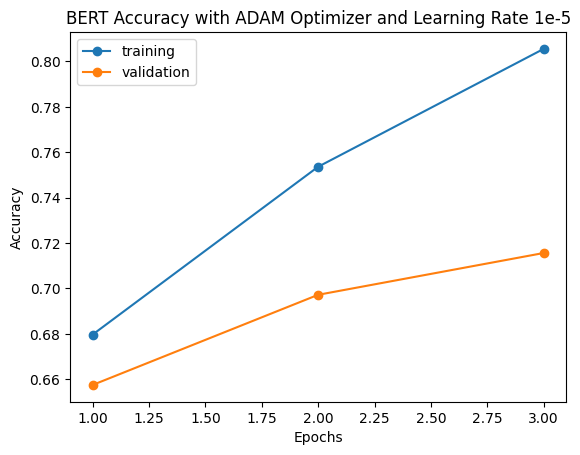

In [31]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]

# accuracy values BERT-Adam
training_accuracy = [0.6797, 0.7536, 0.8055]
validation_accuracy = [0.6575, 0.6972, 0.7156]

plt.plot(epochs, training_accuracy, marker='o', label='training')
plt.plot(epochs, validation_accuracy, marker='o', label='validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BERT Accuracy with ADAM Optimizer and Learning Rate 1e-5')
plt.legend()

plt.show()


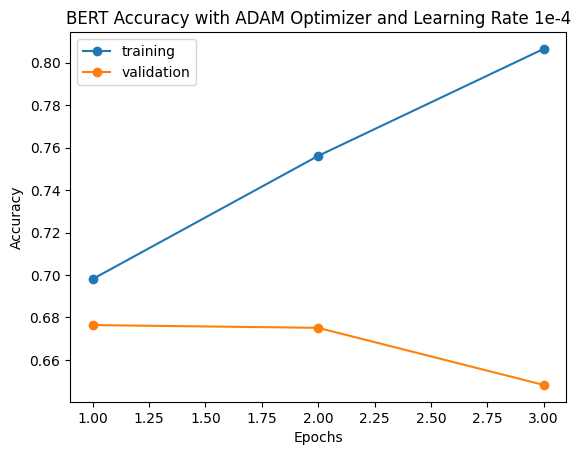

In [32]:
# accuracy values
training_accuracy = [0.6981, 0.7561, 0.8065]
validation_accuracy = [0.6764, 0.6751, 0.6482]

plt.plot(epochs, training_accuracy, marker='o', label='training')
plt.plot(epochs, validation_accuracy, marker='o', label='validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BERT Accuracy with ADAM Optimizer and Learning Rate 1e-4')
plt.legend()

plt.show()


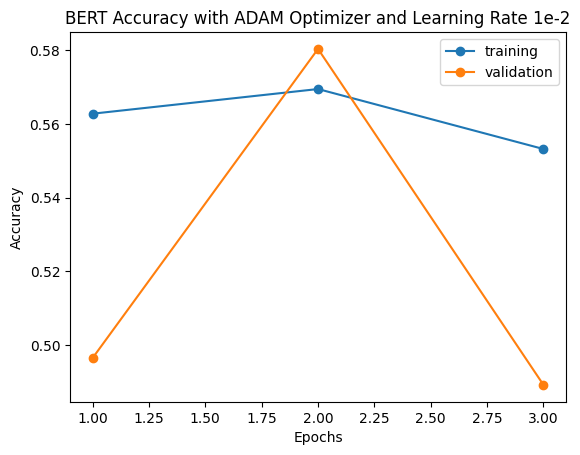

In [33]:
training_accuracy = [0.5628, 0.5695, 0.5532]
validation_accuracy = [0.4964, 0.5804, 0.4891]

plt.plot(epochs, training_accuracy, marker='o', label='training')
plt.plot(epochs, validation_accuracy, marker='o', label='validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BERT Accuracy with ADAM Optimizer and Learning Rate 1e-2')
plt.legend()

plt.show()

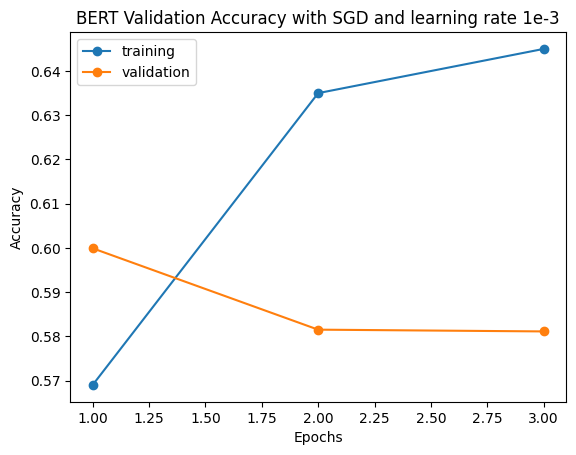

In [34]:
# plotting the best result from gridsearch with SGD optimizer
training_accuracy = [0.5690, 0.6350, 0.6450]
validation_accuracy = [0.5999, 0.5815, 0.5811]


plt.plot(epochs, training_accuracy, marker='o', label='training')
plt.plot(epochs, validation_accuracy, marker='o', label='validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BERT Validation Accuracy with SGD and learning rate 1e-3')
plt.legend()

plt.show()

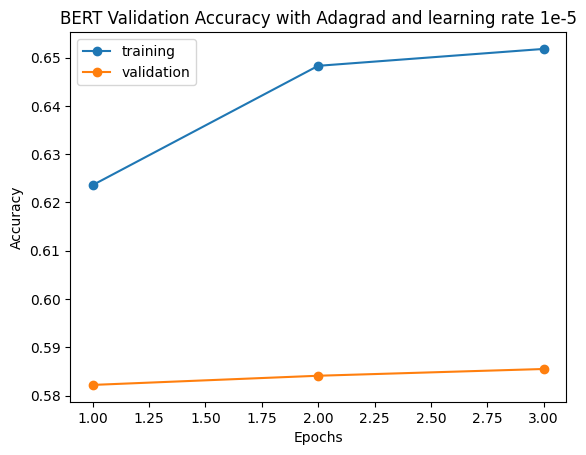

In [35]:
# plotting the best result from gridsearch with Adagrad optimizer
training_accuracy = [0.6236, 0.6483, 0.6518]
validation_accuracy = [0.5822, 0.5841, 0.5855]

plt.plot(epochs, training_accuracy, marker='o', label='training')
plt.plot(epochs, validation_accuracy, marker='o', label='validation')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BERT Validation Accuracy with Adagrad and learning rate 1e-5')
plt.legend()

plt.show()

In [4]:
#the best model is evaluated on the test set

# the best model seems to be the one with Adam as optimizer and 1e-5 as learning rate

test_data=pd.read_csv("arguments-test.tsv", sep="\t")
test_labels=pd.read_csv("labels-test.tsv", sep="\t")

In [5]:
test_data

,Argument ID,Conclusion,Stance,Premise
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...
...,...,...,...,...
1571,E07272,We should end mass migration together.,in favor of,Mass migration is a phenomenon that causes dam...
1572,E07273,We should end mass migration together.,in favor of,Mass migration hurts the migrants themselves i...
1573,E07275,We should consider Russian interests in the EU...,in favor of,It is neither in the interests of the EU nor R...
1574,E07280,We should adopt an extension of the applicatio...,in favor of,Foreign Policy at the EU level should be based...


In [6]:
import spacy

nlp=spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc=nlp(text)
    # set lowercase and remove punctuation
    processed_text=" ".join([token.text.lower() for token in doc if not token.is_punct])
    return processed_text

# Apply text preprocessing to your text data
test_data["processed_text"]=test_data["Premise"].apply(preprocess_text)

In [7]:
test_data

,Argument ID,Conclusion,Stance,Premise,processed_text
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,affirmative action helps with employment equity
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,affirmative action can be considered discrimin...
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,naturopathy is very dangerous for the most vul...
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,women should n't be in combat because they are...
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,once eradicated illnesses are returning due to...
...,...,...,...,...,...
1571,E07272,We should end mass migration together.,in favor of,Mass migration is a phenomenon that causes dam...,mass migration is a phenomenon that causes dam...
1572,E07273,We should end mass migration together.,in favor of,Mass migration hurts the migrants themselves i...,mass migration hurts the migrants themselves i...
1573,E07275,We should consider Russian interests in the EU...,in favor of,It is neither in the interests of the EU nor R...,it is neither in the interests of the eu nor r...
1574,E07280,We should adopt an extension of the applicatio...,in favor of,Foreign Policy at the EU level should be based...,foreign policy at the eu level should be based...


In [17]:
%store -r test_set #stored from the notebook test_preprocessing.ipynb, it is the testing set after some preprocessing (tokenization of premises and generalization of labels)

no stored variable or alias #stored
no stored variable or alias from
no stored variable or alias the
no stored variable or alias notebook
no stored variable or alias test_preprocessing.ipynb,
no stored variable or alias it
no stored variable or alias is
no stored variable or alias the
no stored variable or alias testing
no stored variable or alias set
no stored variable or alias after
no stored variable or alias some
no stored variable or alias preprocessing
no stored variable or alias (tokenization
no stored variable or alias of
no stored variable or alias premises
no stored variable or alias and
no stored variable or alias generalization
no stored variable or alias of
no stored variable or alias labels)


In [18]:
test_set

,Argument ID,Conclusion,Stance,Premise,Argument ID,premise_tokenized,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,general_label,no_stopwords_premise
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,A26004,"[affirmative, action, helps, with, employment,...",0,1,1,2,"[0.0, 0.25, 0.25, 0.5]","[affirmative, action, helps, employment, equity]"
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,A26010,"[affirmative, action, can, be, considered, dis...",0,1,0,3,"[0.0, 0.25, 0.0, 0.75]","[affirmative, action, considered, discriminato..."
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,A26016,"[naturopathy, is, very, dangerous, for, the, m...",0,1,1,2,"[0.0, 0.25, 0.25, 0.5]","[naturopathy, dangerous, vulnerable, people, l..."
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,A26024,"[women, should, n't, be, in, combat, because, ...",0,1,0,0,"[0.0, 1.0, 0.0, 0.0]","[women, n't, combat, n't, strong, fast, men, w..."
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,A26026,"[once, eradicated, illnesses, are, returning, ...",0,1,2,2,"[0.0, 0.2, 0.4, 0.4]","[eradicated, illnesses, returning, due, people..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1571,E07272,We should end mass migration together.,in favor of,Mass migration is a phenomenon that causes dam...,E07272,"[mass, migration, is, a, phenomenon, that, cau...",0,0,1,0,"[0.0, 0.0, 1.0, 0.0]","[mass, migration, phenomenon, causes, damage, ..."
1572,E07273,We should end mass migration together.,in favor of,Mass migration hurts the migrants themselves i...,E07273,"[mass, migration, hurts, the, migrants, themse...",0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666...","[mass, migration, hurts, migrants, immensely]"
1573,E07275,We should consider Russian interests in the EU...,in favor of,It is neither in the interests of the EU nor R...,E07275,"[it, is, neither, in, the, interests, of, the,...",1,1,1,2,"[0.2, 0.2, 0.2, 0.4]","[neither, interests, eu, russia, split, long, ..."
1574,E07280,We should adopt an extension of the applicatio...,in favor of,Foreign Policy at the EU level should be based...,E07280,"[foreign, policy, at, the, eu, level, should, ...",1,1,0,2,"[0.25, 0.25, 0.0, 0.5]","[foreign, policy, eu, level, based, absolute, ..."


In [19]:
#binarize test set labels

labels_binarized=[]

for label in test_set.general_label:
    labels=[]
    for sublabel in label:
        if sublabel>0:
            labels.append(1)
        else:
            labels.append(0)
    labels_binarized.append(labels)

In [20]:
labels_binarized

[[0, 1, 1, 1],
 [0, 1, 0, 1],
 [0, 1, 1, 1],
 [0, 1, 0, 0],
 [0, 1, 1, 1],
 [0, 0, 0, 1],
 [0, 1, 0, 1],
 [1, 0, 0, 1],
 [1, 0, 1, 1],
 [1, 0, 1, 1],
 [0, 1, 1, 0],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 0],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [0, 1, 0, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [1, 0, 0, 1],
 [1, 1, 1, 1],
 [0, 0, 1, 1],
 [0, 1, 1, 1],
 [0, 0, 0, 1],
 [1, 1, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 0, 1],
 [0, 1, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 1, 0, 1],
 [0, 1, 0, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 0],
 [0, 1, 0, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 1, 1],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 1],
 [0, 1, 0, 1],
 [0, 1, 1, 1],
 [0, 0, 0, 1],
 [1, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [0, 0, 0,

In [21]:
df_labels = pd.DataFrame(labels_binarized)

# then we combine the tokenized text with binarized labels
test_combined = pd.concat([test_data['processed_text'], df_labels], axis=1)

In [22]:
test_combined

,processed_text,0,1,2,3
0,affirmative action helps with employment equity,0,1,1,1
1,affirmative action can be considered discrimin...,0,1,0,1
2,naturopathy is very dangerous for the most vul...,0,1,1,1
3,women should n't be in combat because they are...,0,1,0,0
4,once eradicated illnesses are returning due to...,0,1,1,1
...,...,...,...,...,...
1571,mass migration is a phenomenon that causes dam...,0,0,1,0
1572,mass migration hurts the migrants themselves i...,0,0,1,1
1573,it is neither in the interests of the eu nor r...,1,1,1,1
1574,foreign policy at the eu level should be based...,1,1,0,1


Evaluting the best model on the preprocessed test data

In [25]:
# setting again the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenizing text in the test set
test_encodings = tokenizer(list(test_combined['processed_text']), truncation=True, padding='max_length', max_length=64, return_tensors='pt')

# converting labels to tensors with binary values
test_labels = torch.tensor(test_combined.iloc[:, 1:].values, dtype=torch.float32)  

# creating the resulting dataset
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# setting the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  

# moving the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# optimizer and learning rates resulted from gridsearch
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# evaluation on test set
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for input_ids, attention_mask, labels in test_dataloader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Threshold 
        predictions = torch.sigmoid(logits) > 0.5

        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()


accuracy = correct_predictions / total_predictions

print(f'correct_predictions:{correct_predictions}, total_predictios:{total_predictions}')
print(f'Test Accuracy: {accuracy:.4f}')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


correct_predictions:3626, total_predictios:6304
Test Accuracy: 0.5752
